In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sqlalchemy import create_engine, Column, Float, Integer, MetaData, Table
from sqlalchemy.orm import sessionmaker
from math import sqrt
import sys
import re

pd.set_option('display.max_rows', 100)

# Task Description
Your task is to write a Python-program that uses training data to choose the four ideal functions which are the 
best fit out of the fifty provided (C). Afterwards, the program must use the test data provided (B) to determine for each and every x-y pair of values whether or not they can be assigned to the four chosen ideal functions**; if so, the 
program also needs to execute the mapping and save it together with the deviation at hand

* The criterion for choosing the ideal functions for the training function is how they minimize the sum of all y deviations squared (Least-Square)
* The criterion for mapping the individual test case to the four ideal functions is that the existing maximum deviation of the calculated regression does not exceed the largest deviation between training dataset (A) and the ideal function (C) chosen for it by more than factor sqrt(2)

#### Please create a Python-program which also fulfills the following criteria: 
1. Its design is sensibly object-oriented 
2. It includes at least one inheritance 
3. It includes standard- und user-defined exception handlings
4. For logical reasons, it makes use of Pandas’ packages as well as data visualization via Bokeh, sqlalchemy, as well as others
5. Write unit-tests for all useful elements
6. Your code needs to be documented in its entirety and also include Documentation Strings, known as ”docstrings“

In [45]:
def load_csv_to_database(train_path, test_path, ideal_functions_path, database_url):
    """
    Load CSV files into a database as tables.

    Parameters:
        train_path (str): File path for the 'train_MSCS.csv' file.
        test_path (str): File path for the 'test_MSCS.csv' file.
        ideal_functions_path (str): File path for the 'ideal_MSCS.csv' file.
        database_url (str): Connection string for the database (e.g., 'sqlite:///my_database.db').

    Returns:
        None
    """
    # Create a database connection using SQLAlchemy
    engine = create_engine(database_url)

    # Load CSV files into DataFrames
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    ideal_functions = pd.read_csv(ideal_functions_path)

    # Load DataFrames into the database as tables
    train.to_sql('train_data', engine, if_exists='replace', index=False)
    test.to_sql('test_data', engine, if_exists='replace', index=False)
    ideal_functions.to_sql('ideal_functions_data', engine, if_exists='replace', index=False)
    
    # Close the database connection
    engine.dispose()

# Constant Variables
train_file = 'train_MSCS.csv'
test_file = 'test_MSCS.csv'
ideal_functions_file = 'ideal_MSCS.csv'
database_connection = 'sqlite:///my_database.db'

#Call the function to load CSV into the DB
load_csv_to_database(train_file, test_file, ideal_functions_file, database_connection)

# Access the tables in DB
train = pd.read_sql("SELECT * FROM train_data;", engine)
ideal_functions = pd.read_sql("SELECT * FROM ideal_functions_data;", engine)
test = pd.read_sql("SELECT * FROM test_data;", engine)

print(train.shape, ideal_functions.shape, test.shape)

(400, 5) (400, 51) (100, 2)


# Training data

In [18]:
train.head()

,x,y1,y2,y3,y4
0,-20.0,18.667212,4.082132,39.991120,0.494231
1,-19.9,17.047678,4.717633,40.472713,0.770999
2,-19.8,15.777917,4.623225,39.539238,0.196433
3,-19.7,15.209690,4.176161,39.669550,0.387415
4,-19.6,13.815577,4.789562,39.140392,0.573383


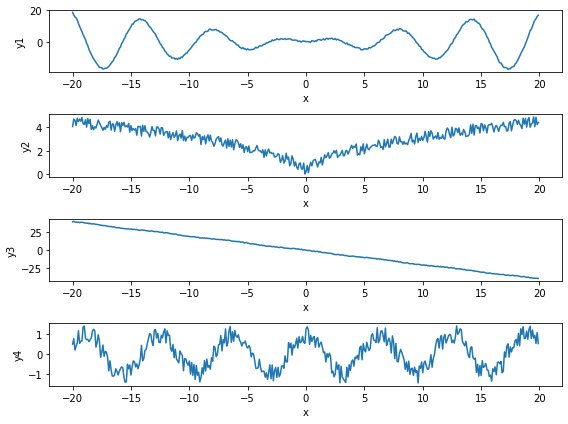

In [19]:
# Get x-values
x = train['x']

# Get y-values for each column
y_values = train[['y1', 'y2', 'y3', 'y4']]

# Create subplots
fig, axes = plt.subplots(nrows=len(y_values.columns), ncols=1, figsize=(8, 6))

# Plot each y-value
for i, column in enumerate(y_values.columns):
    y = y_values[column]
    ax = axes[i]
    ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel(column)

# Adjust spacing between subplots
plt.tight_layout()

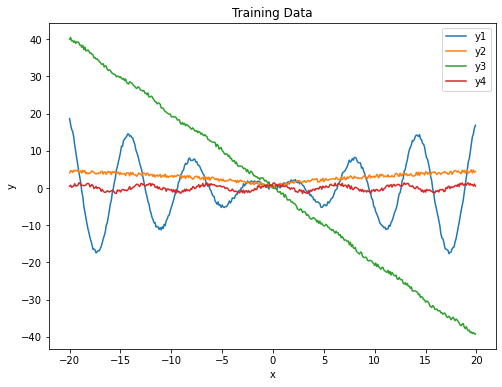

In [20]:
# Get x-values
x = train['x']

# Get y-values for each column
y_values = train[['y1', 'y2', 'y3', 'y4']]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each y-value on the same axes
for column in y_values.columns:
    y = y_values[column]
    ax.plot(x, y, label=column)

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Training Data')

# Add a legend
ax.legend()


# Test Data

In [21]:
test.head()

,x,y
0,-17.5,-20.780668
1,5.0,29.299292
2,-3.5,2.824058
3,4.3,2.295676
4,-14.7,0.082860


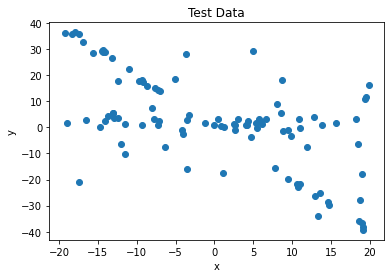

In [22]:
# Visualize the data
plt.scatter(test['x'], test['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Test Data')
plt.show()

# Ideal Functions

Text(0.5, 1.0, 'Ideal Functions')

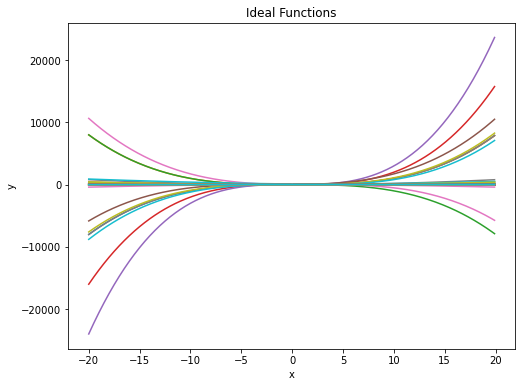

In [25]:
# Get x-values
x = ideal_functions['x']

# Get y-values for each column
y_values = ideal_functions.drop('x',axis=1)

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each y-value on the same axes
for column in y_values.columns:
    y = y_values[column]
    ax.plot(x, y, label=column)

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Ideal Functions')


# Task 1: Find 4 Ideal Functions

## Selecting 4 Ideal Functions based on MSE

In [29]:
# Columns to consider for matching (exclude 'x' column)
y_columns_train = [col for col in train.columns if col.startswith('y')]
y_columns_ideal = [col for col in ideal_functions.columns if col.startswith('y')]

# Function to calculate mean squared error (MSE)
def calculate_mse(y1, y2):
    return np.mean((y1 - y2) ** 2)

In [30]:
# Dictionary to store the closest match for each 'y' feature
closest_matches = {}

# Loop through each 'y' feature in the train set
for y_col_train in y_columns_train:
    # Get the 'y' feature from the train set
    y_train = train[y_col_train]

    # Initialize variables to keep track of the best match
    best_match = None
    best_mse = float('inf')  # Initialize with a high value

    # Loop through each 'y' feature in the ideal set
    for y_col_ideal in y_columns_ideal:
        # Get the 'y' feature from the ideal set
        y_ideal = ideal_functions[y_col_ideal]

        # Calculate the mean squared error (MSE) between the train and ideal 'y' features
        mse = calculate_mse(y_train, y_ideal)

        # Update the best match if a better match is found
        if mse < best_mse:
            best_match = y_col_ideal
            best_mse = mse

    # Store the best match for the current 'y' feature in the dictionary
    closest_matches[y_col_train] = best_match

# Print the closest matches
for y_col_train, y_col_ideal in closest_matches.items():
    print(f"{y_col_train}(train) has the lowest MSE with {y_col_ideal}(ideal)")

y1(train) has the lowest MSE with y10(ideal)
y2(train) has the lowest MSE with y32(ideal)
y3(train) has the lowest MSE with y42(ideal)
y4(train) has the lowest MSE with y2(ideal)


In [35]:
# Create an empty list to store the results
results_list_mse = []

# Loop through each 'y' feature in the train set
for y_col_train in y_columns_train:
    # Get the 'y' feature from the train set
    y_train = train[y_col_train]

    # Initialize variables to keep track of the best match
    best_match = None
    best_mse = float('inf')  # Initialize with a high value

    # Loop through each 'y' feature in the ideal set
    for y_col_ideal in y_columns_ideal:
        # Get the 'y' feature from the ideal set
        y_ideal = ideal_functions[y_col_ideal]

        # Calculate the mean squared error (MSE) between the train and ideal 'y' features
        mse = calculate_mse(y_train, y_ideal)

        # Update the best match if a better match is found
        if mse < best_mse:
            best_match = y_col_ideal
            best_mse = mse

    # Append the best match for the current 'y' feature to the results list
    results_list_mse.append({
        'train': y_col_train,
        'ideal': best_match,
        'MSE': best_mse
    })

# Create a DataFrame from the results list
results_df_mse = pd.concat([pd.DataFrame([result]) for result in results_list_mse], ignore_index=True)

# Print the final DataFrame with the results
results_df_mse

,train,ideal,MSE
0,y1,y10,0.090587
1,y2,y32,0.087107
2,y3,y42,0.083512
3,y4,y2,0.085755


## Selecting 4 Ideal Functions Based on LSE 

In [34]:
# Columns to consider for matching (exclude 'x' column)
y_columns_train = [col for col in train.columns if col.startswith('y')]
y_columns_ideal = [col for col in ideal_functions.columns if col.startswith('y')]

# Function to calculate sum of squared errors (SSE) or LSE
def calculate_lse(y1, y2):
    return np.sum((y1 - y2) ** 2)

# Create an empty list to store the results
results_list_lse = []

# Loop through each 'y' feature in the train set
for y_col_train in y_columns_train:
    # Get the 'y' feature from the train set
    y_train = train[y_col_train]

    # Initialize variables to keep track of the best match
    best_match = None
    best_lse = float('inf')  # Initialize with a high value

    # Loop through each 'y' feature in the ideal set
    for y_col_ideal in y_columns_ideal:
        # Get the 'y' feature from the ideal set
        y_ideal = ideal_functions[y_col_ideal]

        # Calculate the sum of squared errors (SSE) between the train and ideal 'y' features
        lse = calculate_lse(y_train, y_ideal)

        # Update the best match if a better match is found
        if lse < best_lse:
            best_match = y_col_ideal
            best_lse = lse

    # Append the best match for the current 'y' feature to the results list
    results_list_lse.append({
        'train': y_col_train,
        'ideal': best_match,
        'LSE': best_lse
    })

# Create a DataFrame from the results list
results_df_lse = pd.concat([pd.DataFrame([result]) for result in results_list_lse], ignore_index=True)

# Print the final DataFrame with the results
results_df_lse

# Task 2: Mapping Selected Ideal Functions to Test Set

## Mapping Based on Max(MSE) 

In [38]:
# Read the datasets
train = pd.read_csv('train_MSCS.csv')
ideal_functions = pd.read_csv('ideal_MSCS.csv')

# Columns to consider for matching (exclude 'x' column)
y_columns_train = [col for col in train.columns if col.startswith('y')]
y_columns_ideal = [col for col in ideal_functions.columns if col.startswith('y')]

# Function to calculate mean squared error (MSE)
def calculate_mse(y1, y2):
    return np.mean((y1 - y2) ** 2)

# Create an empty list to store the results
results_list_mse = []

# Loop through each 'y' feature in the train set
for y_col_train in y_columns_train:
    # Get the 'y' feature from the train set
    y_train = train[y_col_train]

    # Initialize variables to keep track of the best match
    best_match = None
    best_mse = float('inf')  # Initialize with a high value

    # Loop through each 'y' feature in the ideal set
    for y_col_ideal in y_columns_ideal:
        # Get the 'y' feature from the ideal set
        y_ideal = ideal_functions[y_col_ideal]

        # Calculate the mean squared error (MSE) between the train and ideal 'y' features
        mse = calculate_mse(y_train, y_ideal)

        # Update the best match if a better match is found
        if mse < best_mse:
            best_match = y_col_ideal
            best_mse = mse

    # Append the best match for the current 'y' feature to the results list
    results_list_mse.append({
        'train': y_col_train,
        'ideal': best_match,
        'MSE': best_mse
    })

# Create a DataFrame from the results list
results_df_mse = pd.concat([pd.DataFrame([result]) for result in results_list_mse], ignore_index=True)

In [43]:
# Create an empty list to store the results
task2_results_list = []

# Get the list of ideal 'y' column names from results_df_mse
selected_ideal_y_columns = list(results_df_mse['ideal'])

# Loop through each row in the test set
for index, row in test.iterrows():
    x_value = row['x']
    y_value = row['y']

    # Initialize variables to keep track of the best match for the current row
    best_match = None
    best_mse = float('inf')  # Initialize with a high value

    # Calculate MSE for each 'y' feature in the ideal set for the current row
    for y_col_ideal in selected_ideal_y_columns:
        # Get the 'y' feature from the ideal set
        y_ideal_values = ideal_functions[y_col_ideal]

        # Loop through each value in the 'y' feature column of the ideal set
        for y_ideal_value in y_ideal_values:
        # Calculate the MSE between the test 'Y' value and the current 'y' feature value in the ideal set
            mse = calculate_mse(y_value, y_ideal_value)

            # Update the best match if a better match is found
            if mse < best_mse:
                best_match = y_col_ideal
                best_mse = mse

    # Compare with MAX(MSE from task1 results_df) * sqrt(2)
    max_mse_task1 = results_df_mse['MSE'].max()
    threshold_mse = max_mse_task1 * np.sqrt(2)

    # Assign the ideal function if lowest MSE < threshold MSE
    if best_mse < threshold_mse:
        assigned_ideal = best_match
        deviation = best_mse
    else:
        assigned_ideal = "None"
        deviation = None

    # Store the result in the DataFrame
    task2_results_list.append({
        'Test (X)': x_value,
        'Test (Y)': y_value,
        'Deviation': deviation,
        'Assigned Ideal Function': assigned_ideal})

    
# Create a DataFrame from the results list
task2_results_df_mse = pd.concat([pd.DataFrame([result]) for result in task2_results_list], ignore_index=True)
# Print the final DataFrame with the results for task 2
task2_results_df_mse

,Test (X),Test (Y),Deviation,Assigned Ideal Function
0,-1.750000e+01,-20.780668,5.538962e-04,y42
1,5.000000e+00,29.299292,4.855302e-05,y42
2,-3.500000e+00,2.824058,1.909166e-05,y32
3,4.300000e+00,2.295676,4.221361e-05,y32
4,-1.470000e+01,0.082860,2.151656e-05,y2
5,1.190000e+01,-7.675941,5.154762e-04,y10
6,-9.200000e+00,17.439630,5.234088e-03,y42
7,1.470000e+01,-29.664783,4.036081e-06,y42
8,1.200000e+00,0.053962,4.435560e-11,y2
9,4.100000e+00,1.000337,1.138388e-07,y32


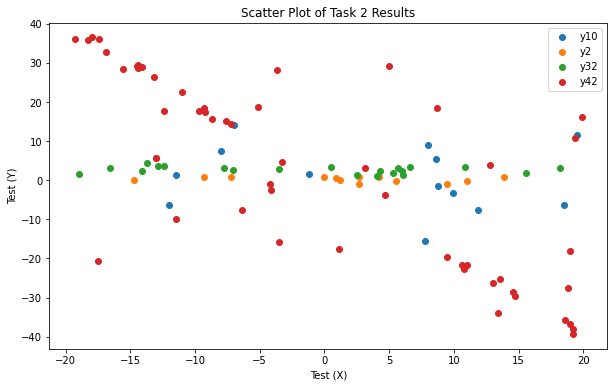

In [47]:
# Visualization
plt.figure(figsize=(10, 6))

# Group the DataFrame by "Assigned Ideal Function"
grouped_data = task2_results_df_mse.groupby("Assigned Ideal Function")

# Create a scatter plot for each group with a unique color
for name, group in grouped_data:
    plt.scatter(group["Test (X)"], group["Test (Y)"], label=name)

# Set plot labels and title
plt.xlabel("Test (X)")
plt.ylabel("Test (Y)")
plt.title("Scatter Plot of Task 2 Results")
plt.legend()

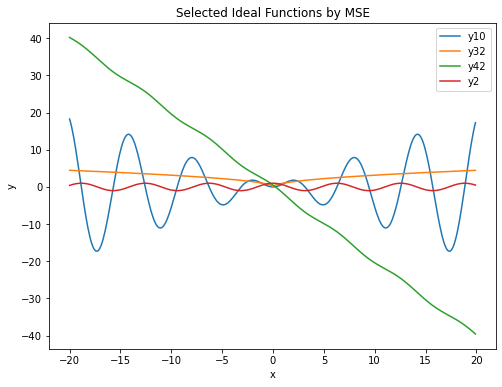

In [48]:
# Get x-values
x = ideal_functions['x']

# Get y-values for each column
y_values = ideal_functions[list(results_df_mse['ideal'])]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each y-value on the same axes
for column in y_values.columns:
    y = y_values[column]
    ax.plot(x, y, label=column)

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Selected Ideal Functions by MSE')
ax.legend()

## Mapping Based on Max(LSE) 

        Test (X)   Test (Y)     Deviation Assigned Ideal Function
0  -1.750000e+01 -20.780668  5.538962e-04                     y42
1   5.000000e+00  29.299292  4.855302e-05                     y42
2  -3.500000e+00   2.824058  1.909166e-05                     y32
3   4.300000e+00   2.295676  4.221361e-05                     y32
4  -1.470000e+01   0.082860  2.151656e-05                      y2
5   1.190000e+01  -7.675941  5.154762e-04                     y10
6  -9.200000e+00  17.439630  5.234088e-03                     y42
7   1.470000e+01 -29.664783  4.036081e-06                     y42
8   1.200000e+00   0.053962  4.435560e-11                      y2
9   4.100000e+00   1.000337  1.138388e-07                     y32
10  1.390000e+01   0.795069  5.558299e-07                      y2
11  1.100000e+00 -17.467976  5.095675e-03                     y42
12  1.100000e+01 -21.710510  1.780890e-04                     y42
13 -7.800000e+00   3.080530  2.813335e-06                     y32
14 -1.8300

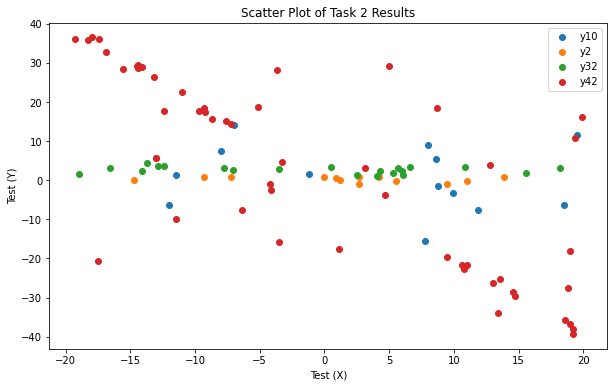

In [62]:
# Constant Variables
train_file = 'train_MSCS.csv'
test_file = 'test_MSCS.csv'
ideal_functions_file = 'ideal_MSCS.csv'
database_connection = 'sqlite:///my_database.db'

#Call the function to load CSV into the DB
load_csv_to_database(train_file, test_file, ideal_functions_file, database_connection)

# Access the tables in DB
train = pd.read_sql("SELECT * FROM train_data;", engine)
ideal_functions = pd.read_sql("SELECT * FROM ideal_functions_data;", engine)
test = pd.read_sql("SELECT * FROM test_data;", engine)


# Columns to consider for matching (exclude 'x' column)
y_columns_train = [col for col in train.columns if col.startswith('y')]
y_columns_ideal = [col for col in ideal_functions.columns if col.startswith('y')]

# Function to calculate sum of squared errors (SSE) or LSE
def calculate_lse(y1, y2):
    return np.sum((y1 - y2) ** 2)

# Create an empty list to store the results
results_list_lse = []

# Loop through each 'y' feature in the train set
for y_col_train in y_columns_train:
    # Get the 'y' feature from the train set
    y_train = train[y_col_train]

    # Initialize variables to keep track of the best match
    best_match = None
    best_lse = float('inf')  # Initialize with a high value

    # Loop through each 'y' feature in the ideal set
    for y_col_ideal in y_columns_ideal:
        # Get the 'y' feature from the ideal set
        y_ideal = ideal_functions[y_col_ideal]

        # Calculate the sum of squared errors (SSE) between the train and ideal 'y' features
        lse = calculate_lse(y_train, y_ideal)

        # Update the best match if a better match is found
        if lse < best_lse:
            best_match = y_col_ideal
            best_lse = lse

    # Append the best match for the current 'y' feature to the results list
    results_list_lse.append({
        'train': y_col_train,
        'ideal': best_match,
        'LSE': best_lse
    })

# Create a DataFrame from the results list
results_df_lse = pd.concat([pd.DataFrame([result]) for result in results_list_lse], ignore_index=True)

# Create an empty list to store the results
task2_results_list = []

# Get the list of ideal 'y' column names from results_df_mse
selected_ideal_y_columns = list(results_df_mse['ideal'])

# Loop through each row in the test set
for index, row in test.iterrows():
    x_value = row['x']
    y_value = row['y']

    # Initialize variables to keep track of the best match for the current row
    best_match = None
    best_lse = float('inf')  # Initialize with a high value

    # Calculate MSE for each 'y' feature in the ideal set for the current row
    for y_col_ideal in selected_ideal_y_columns:
        # Get the 'y' feature from the ideal set
        y_ideal_values = ideal_functions[y_col_ideal]

        # Loop through each value in the 'y' feature column of the ideal set
        for y_ideal_value in y_ideal_values:
        # Calculate the MSE between the test 'Y' value and the current 'y' feature value in the ideal set
            mse = calculate_lse(y_value, y_ideal_value)

            # Update the best match if a better match is found
            if mse < best_lse:
                best_match = y_col_ideal
                best_lse = mse

    # Compare with MAX(LSE from task1 results_df) * sqrt(2)
    max_lse_task1 = results_df_lse['LSE'].max()
    threshold_lse = max_lse_task1 * np.sqrt(2)

    # Assign the ideal function if lowest MSE < threshold MSE
    if best_lse < threshold_lse:
        assigned_ideal = best_match
        deviation = best_lse
    else:
        assigned_ideal = "None"
        deviation = None

    # Store the result in the DataFrame
    task2_results_list.append({
        'Test (X)': x_value,
        'Test (Y)': y_value,
        'Deviation': deviation,
        'Assigned Ideal Function': assigned_ideal})

    
# Create a DataFrame from the results list
task2_results_df_lse = pd.concat([pd.DataFrame([result]) for result in task2_results_list], ignore_index=True)
# Print the final DataFrame with the results for task 2
print(task2_results_df_lse)

# Visualization
plt.figure(figsize=(10, 6))

# Group the DataFrame by "Assigned Ideal Function"
grouped_data = task2_results_df_lse.groupby("Assigned Ideal Function")

# Create a scatter plot for each group with a unique color
for name, group in grouped_data:
    plt.scatter(group["Test (X)"], group["Test (Y)"], label=name)

# Set plot labels and title
plt.xlabel("Test (X)")
plt.ylabel("Test (Y)")
plt.title("Scatter Plot of Task 2 Results")
plt.legend()

# Code as per "Details" Section

### Function to load libraries 

In [7]:
def load_libraries():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import csv
    from sqlalchemy import create_engine, Column, Float, Integer, MetaData, Table
    from sqlalchemy.orm import sessionmaker
    from math import sqrt
    import sys
    import re

    print("Libraries loaded successfully!")
    return pd, np, plt, csv, create_engine, Column, Float, Integer, MetaData, Table, sessionmaker, sqrt, sys, re

# Call the function to load all libraries and store them in global variables
pd, np, plt, csv, create_engine, Column, Float, Integer, MetaData, Table, sessionmaker, sqrt, sys, re = load_libraries()

Libraries loaded successfully!


### Function to get exception Info 

In [22]:
def get_exception_info():
    exception = []
    exception_type, exception_value, exception_traceback = sys.exc_info()
    filename, line_number, procedure_name, linecode = traceback.extract_tb(exception_traceback)[-1]
    exception.append({
        "exception_type":exception_type, 
        "exception_value":exception_value, 
        "exception_traceback":[filename, line_number, procedure_name, linecode]
    })
    return exception

In [ ]:
class CustomException(Exception):
    def __init__(self, message):
        super().__init__(message)

class ExceptionHandler:
    def __init__(self):
        pass

    def standard_exception(self):
        try:
            # Some operation that might raise a standard exception
            result = 10 / 0  # Division by zero to raise a ZeroDivisionError
        except ZeroDivisionError as e:
            print("Standard exception (ZeroDivisionError) occurred:", e)
        except Exception as e:
            print("Standard exception occurred:", e)

    def custom_exception(self):
        try:
            raise CustomException("This is a custom exception.")
        except CustomException as e:
            print("Custom exception (CustomException) occurred:", e)

    def handle_multiple_exceptions(self):
        try:
            # Some operation that might raise multiple exceptions
            result = int("not_an_integer")
            result = 10 / 0
        except ZeroDivisionError as e:
            print("ZeroDivisionError occurred:", e)
        except ValueError as e:
            print("ValueError occurred:", e)
        except Exception as e:
            print("Other exception occurred:", e)

if __name__ == "__main__":
    exception_handler = ExceptionHandler()

    # Handling standard exception (ZeroDivisionError)
    print("Handling standard exception:")
    exception_handler.standard_exception()

    # Handling custom exception (CustomException)
    print("\nHandling custom exception:")
    exception_handler.custom_exception()

    # Handling multiple exceptions
    print("\nHandling multiple exceptions:")
    exception_handler.handle_multiple_exceptions()


### Function to load CSV files into DB 

In [35]:
def load_csv_to_database(train_path, test_path, ideal_functions_path):
    database_connection = 'sqlite:///my_database.db'
    # Create a database connection using SQLAlchemy
    engine = create_engine(database_connection)
    files_list = [train_path, test_path, ideal_functions_path]
    error_flag = False  # Initialize error flag as False

    # Load CSV files into DataFrames
    for file in files_list:
        if 'train' in file:
            try:
                train = pd.read_csv(file)
                # Load DataFrames into the database as tables
                train.to_sql('train_data', engine, if_exists='replace', index=False)
            except Exception as e:
                print(f"Error in loading Train Set from {file}:\n{str(e)}")
                error_flag = True

        elif 'ideal' in file:
            try:
                ideal_functions = pd.read_csv(file)
                # Load DataFrames into the database as tables
                ideal_functions.to_sql('ideal_functions_data', engine, if_exists='replace', index=False)
            except Exception as e:
                print(f"Error in loading Ideal Set from {file}:\n{str(e)}")
                error_flag = True

        elif 'test' in file:
            try:
                test = pd.read_csv(file)
                # Load DataFrames into the database as tables
                test.to_sql('test_data', engine, if_exists='replace', index=False)
            except Exception as e:
                print(f"Error in loading Test Set from {file}:\n{str(e)}")
                error_flag = True

    # Close the database connection
    engine.dispose()

    # Print "All Files loaded successfully!" if no errors occurred during loading
    if not error_flag:
        print("All Files loaded into the DB successfully!")

### Function to load CSV files into DataFrames 

In [92]:
def load_csv(train_path, test_path, ideal_functions_path):
    files_list = [train_path, test_path, ideal_functions_path]
    error_flag = False  # Initialize error flag as False

    # Load CSV files into DataFrames
    for file in files_list:
        if 'train' in file:
            try:
                train = pd.read_csv(file)
            except Exception as e:
                print(f"Error in loading Train Set from {file}:\n{str(e)}")
                error_flag = True

        elif 'ideal' in file:
            try:
                ideal_functions = pd.read_csv(file)
            except Exception as e:
                print(f"Error in loading Ideal Set from {file}:\n{str(e)}")
                error_flag = True

        elif 'test' in file:
            try:
                test = pd.read_csv(file)
            except Exception as e:
                print(f"Error in loading Test Set from {file}:\n{str(e)}")
                error_flag = True

    # Print "All Files loaded successfully!" if no errors occurred during loading
    if not error_flag:
        return train, ideal_functions, test

# OOP Code

Libraries loaded successfully!
All Files loaded into the DB successfully!


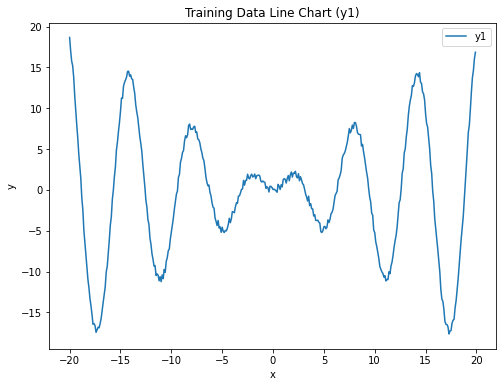

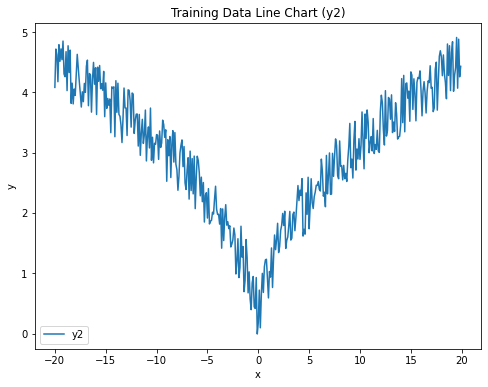

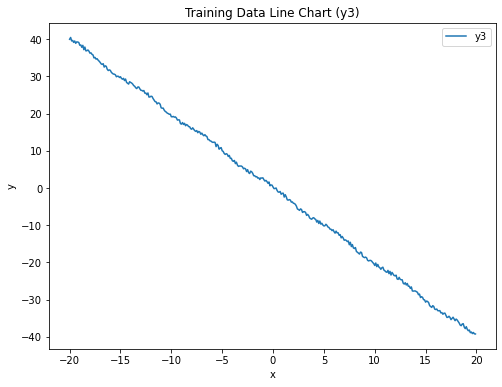

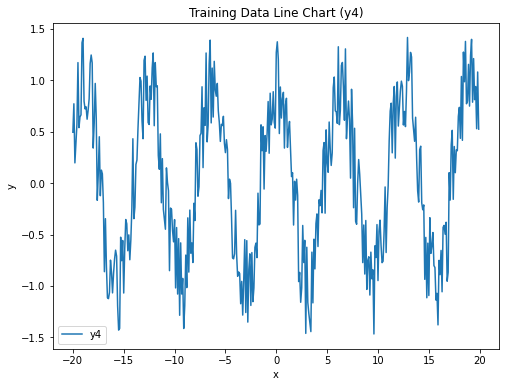

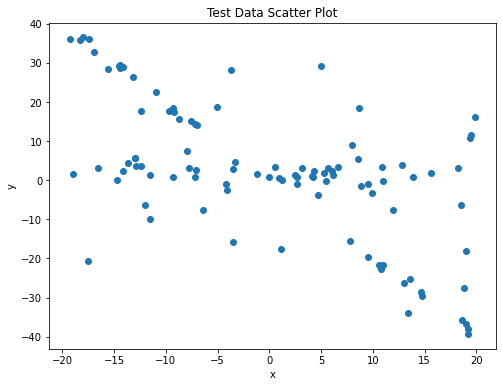

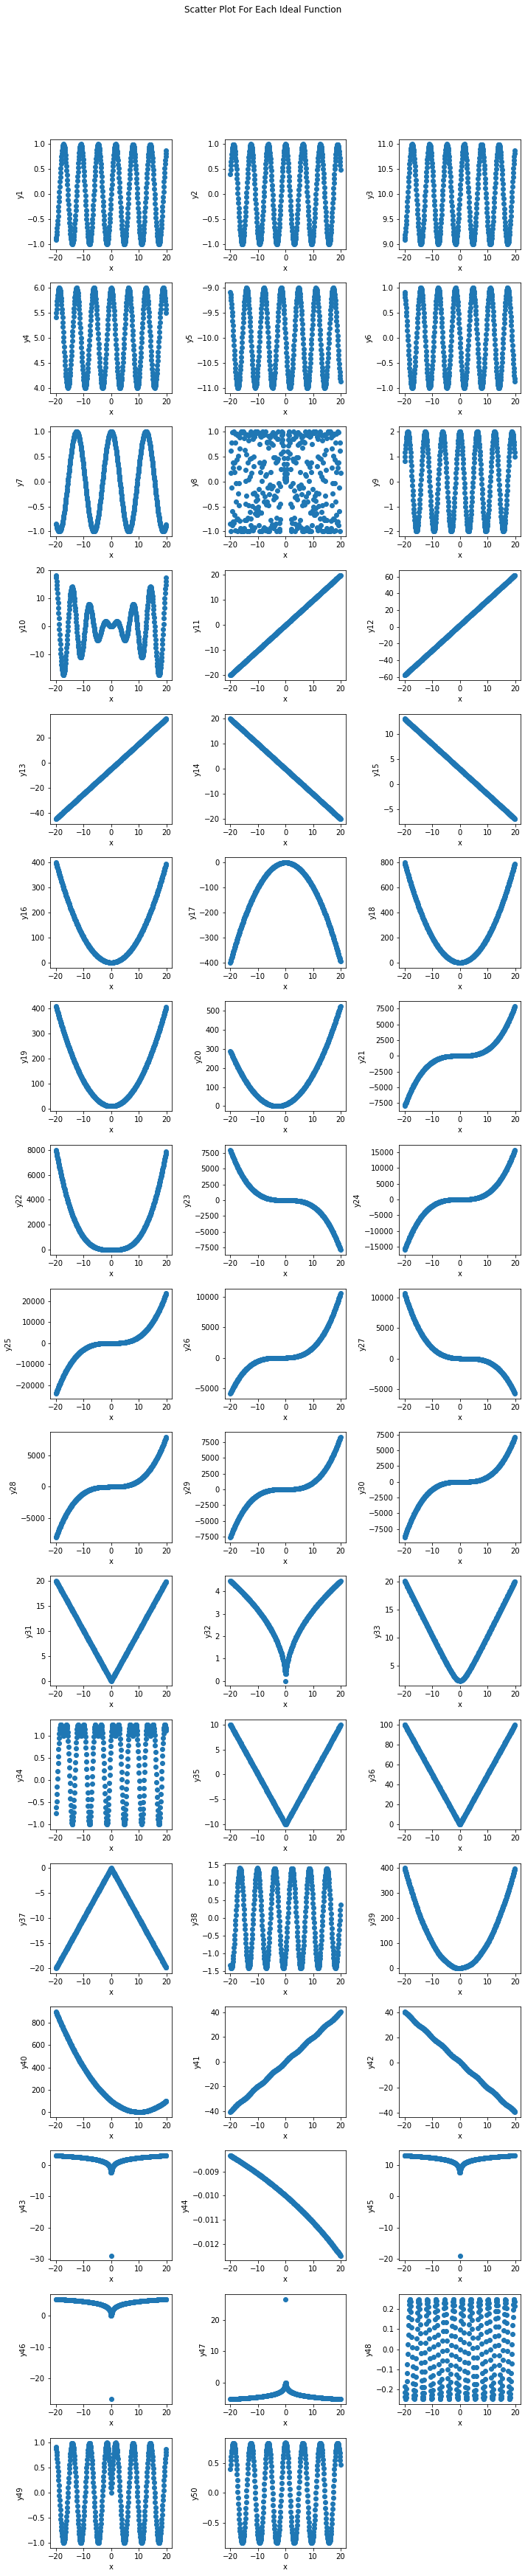

DataFrame loaded as table 'task_2_output' into the database successfully!


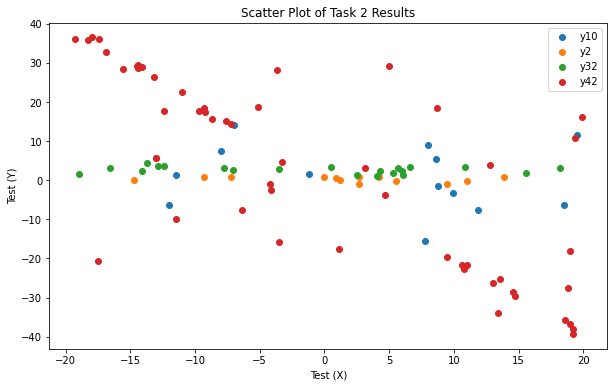

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sqlalchemy import create_engine, Column, Float, Integer, MetaData, Table
from sqlalchemy.orm import sessionmaker
from math import sqrt
import sys
import re

print("Libraries loaded successfully!")

# Custom Exception classes
class DataLoadException(Exception):
    pass

class DatabaseConnectionException(Exception):
    pass

class DataFrameToSQLException(Exception):
    pass

class VisualizationException(Exception):
    pass

class IdealFunctionSelectorException(Exception):
    pass

class IdealFunctionMappingException(Exception):
    pass

class LoadData():
    def __init__(self,train_path, test_path, ideal_functions_path):
        self.train_path = train_path
        self.test_path = test_path
        self.ideal_functions_path = ideal_functions_path
    
    def load_csv_to_database(self):
        database_connection = 'sqlite:///my_database.db'
        try:
            # Create a database connection using SQLAlchemy
            engine = create_engine(database_connection)
            files_list = [self.train_path, self.test_path, self.ideal_functions_path]
            error_flag = False  # Initialize error flag as False

            # Load CSV files into DataFrames
            for file in files_list:
                if 'train' in file:
                    try:
                        train = pd.read_csv(file)
                        # Load DataFrames into the database as tables
                        train.to_sql('train_data', engine, if_exists='replace', index=False)
                    except Exception as e:
                        raise DataLoadException(f"Error in loading Train Set from {file}:\n{str(e)}")
                        error_flag = True

                elif 'ideal' in file:
                    try:
                        ideal_functions = pd.read_csv(file)
                        # Load DataFrames into the database as tables
                        ideal_functions.to_sql('ideal_functions_data', engine, if_exists='replace', index=False)
                    except Exception as e:
                        raise DataLoadException(f"Error in loading Ideal Set from {file}:\n{str(e)}")
                        error_flag = True

                elif 'test' in file:
                    try:
                        test = pd.read_csv(file)
                        # Load DataFrames into the database as tables
                        test.to_sql('test_data', engine, if_exists='replace', index=False)
                    except Exception as e:
                        raise DataLoadException(f"Error in loading Test Set from {file}:\n{str(e)}")
                        error_flag = True

            # Close the database connection
            engine.dispose()

            # Print "All Files loaded successfully!" if no errors occurred during loading
            if not error_flag:
                print("All Files loaded into the DB successfully!")
                return train, ideal_functions, test
        except Exception as e:
            raise DatabaseConnectionException(f"Error in creating the database connection:\n{str(e)}")

#Child Class
class DataFrameToSQL(LoadData):
    def __init__(self, train_path, test_path, ideal_functions_path):
        super().__init__(train_path, test_path, ideal_functions_path)

    def load_dataframe_to_sql(self, dataframe, table_name, database_connection='sqlite:///my_database.db'):
        # Create a database connection using SQLAlchemy
        engine = create_engine(database_connection)

        try:
            # Load the DataFrame into the database as a table
            dataframe.to_sql(table_name, engine, if_exists='replace', index=False)
            print(f"DataFrame loaded as table '{table_name}' into the database successfully!")
        except Exception as e:
            raise DataFrameToSQLException(f"Error in loading DataFrame as table into the database:\n{str(e)}")

        # Close the database connection
        engine.dispose()

class Visualise():
    def __init__(self, train, test, ideal_functions):
        self.train = train
        self.test = test
        self.ideal_functions = ideal_functions
    
    def visualise_train(self):
        try:
            # Get x-values
            x = self.train['x']
            # Get y-values for each column
            y_values = self.train[['y1', 'y2', 'y3', 'y4']]
            # Create a separate plot for each y-value
            for column in y_values.columns:
                y = y_values[column]
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.plot(x, y, label=column)
                ax.set_xlabel('x')
                ax.set_ylabel('y')
                ax.set_title(f'Training Data Line Chart ({column})')
                ax.legend()
                plt.show()
        except Exception as e:
            raise VisualizationException(f"Error in Visualising Train Set\nError:{e}")
        
    def visualise_test(self):
        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.scatter(self.test['x'], self.test['y'])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Test Data Scatter Plot')
            plt.show()
        except Exception as e:
            raise VisualizationException(f"Error in Visualising Test Set\nError:{e}")
    
    def visualise_ideal(self):
        try:
            data = self.ideal_functions
            # We know that our data set always contains one "x" column
            x = data['x']
            # Get the list of 'y' column names (excluding the 'x' column)
            y_columns = [col for col in data.columns if col != 'x']

            # Plotting separate scatter plots for each 'x' and 'y' pair
            num_plots = len(y_columns)
            num_cols = 3  # Number of columns in the grid of subplots
            num_rows = (num_plots + num_cols - 1) // num_cols

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
            fig.suptitle('Scatter Plot For Each Ideal Function', fontsize=12)

            for i, y_col in enumerate(y_columns):
                row_idx = i // num_cols
                col_idx = i % num_cols
                ax = axes[row_idx, col_idx]
                ax.scatter(data['x'], data[y_col])
                ax.set_xlabel('x')
                ax.set_ylabel(y_col)

            # Remove any empty subplots
            if num_plots < num_rows * num_cols:
                for i in range(num_plots, num_rows * num_cols):
                    fig.delaxes(axes.flatten()[i])

            plt.tight_layout(rect=[0, 0.03, 1, 0.94])  # Adjust spacing between subplots
            plt.show()
        
        except Exception as e:
            raise VisualizationException(f"Error in Visualising Ideal Set\nError:{e}")
    
    
    def visualise_task_2_output(self,data):
        try:
            plt.figure(figsize=(10, 6))

            # Group the DataFrame by "Assigned Ideal Function"
            grouped_data = data.groupby("Assigned Ideal Function")

            # Create a scatter plot for each group with a unique color
            for name, group in grouped_data:
                plt.scatter(group["Test (X)"], group["Test (Y)"], label=name)

            # Set plot labels and title
            plt.xlabel("Test (X)")
            plt.ylabel("Test (Y)")
            plt.title("Scatter Plot of Task 2 Results")
            plt.legend()
        
        except Exception as e:
            raise VisualizationException(f"Error in Visualising Test Set\nError:{e}")
    

class IdealFunctionSelector():
    def __init__(self, train, ideal_functions):
        self.train = train
        self.ideal_functions = ideal_functions
    
    def calculate_lse(self, y1, y2):
        return np.sum((y1 - y2) ** 2)

    def select_ideal_functions(self):
        try:
            # Columns to consider for matching (exclude 'x' column)
            y_columns_train = [col for col in self.train.columns if col.startswith('y')]
            y_columns_ideal = [col for col in self.ideal_functions.columns if col.startswith('y')]  

            # Create an empty list to store the results
            results_list_lse = []

            # Loop through each 'y' feature in the train set
            for y_col_train in y_columns_train:
                # Get the 'y' feature from the train set
                y_train = self.train[y_col_train]

                # Initialize variables to keep track of the best match
                best_match = None
                best_lse = float('inf')  # Initialize with a high value

                # Loop through each 'y' feature in the ideal set
                for y_col_ideal in y_columns_ideal:
                    # Get the 'y' feature from the ideal set
                    y_ideal = self.ideal_functions[y_col_ideal]

                    # Calculate the sum of squared errors (SSE) between the train and ideal 'y' features
                    lse = self.calculate_lse(y_train, y_ideal)

                    # Update the best match if a better match is found
                    if lse < best_lse:
                        best_match = y_col_ideal
                        best_lse = lse

                # Append the best match for the current 'y' feature to the results list
                results_list_lse.append({
                    'train': y_col_train,
                    'ideal': best_match,
                    'LSE': best_lse
                })

            # Create a DataFrame from the results list
            results_df_lse = pd.concat([pd.DataFrame([result]) for result in results_list_lse], ignore_index=True)

            # Return the final DataFrame with the results
            return results_df_lse
        
        except Exception as e:
            raise IdealFunctionSelectorException(f"Error encountered:{e}")

class IdealFunctionMapper():
    def __init__(self, test, task_1_output, ideal_functions):
        self.test = test
        self.task_1_output = task_1_output
        self.ideal_functions = ideal_functions
        self.selector = IdealFunctionSelector(train, ideal_functions)
    
    def map_ideal_functions(self):
        try:
            # Create an empty list to store the results
            task2_results_list = []

            # Get the list of ideal 'y' column names from task_1_output
            selected_ideal_y_columns = list(self.task_1_output['ideal'])

            # Loop through each row in the test set
            for index, row in self.test.iterrows():
                x_value = row['x']
                y_value = row['y']

                # Initialize variables to keep track of the best match for the current row
                best_match = None
                best_lse = float('inf')  # Initialize with a high value

                # Calculate LSE for each 'y' feature in the ideal set for the current row
                for y_col_ideal in selected_ideal_y_columns:
                    # Get the 'y' feature from the ideal set
                    y_ideal_values = self.ideal_functions[y_col_ideal]

                    # Loop through each value in the 'y' feature column of the ideal set
                    for y_ideal_value in y_ideal_values:
                    # Calculate the LSE between the test 'Y' value and the current 'y' feature value in the ideal set
                        lse = self.selector.calculate_lse(y_value, y_ideal_value)

                        # Update the best match if a better match is found
                        if lse < best_lse:
                            best_match = y_col_ideal
                            best_lse = lse

                # Compare with MAX(LSE from task_1_output) * sqrt(2)
                max_lse_task1 = self.task_1_output['LSE'].max()
                threshold_lse = max_lse_task1 * np.sqrt(2)

                # Assign the ideal function if lowest LSE < threshold LSE
                if best_lse < threshold_lse:
                    assigned_ideal = best_match
                    deviation = best_lse
                else:
                    assigned_ideal = "None"
                    deviation = None

                # Store the result in the DataFrame
                task2_results_list.append({
                    'Test (X)': x_value,
                    'Test (Y)': y_value,
                    'Deviation': deviation,
                    'Assigned Ideal Function': assigned_ideal})


            # Create a DataFrame from the results list
            task2_results_df_lse = pd.concat([pd.DataFrame([result]) for result in task2_results_list], ignore_index=True)

            # return the final DataFrame with the results for task 2
            return task2_results_df_lse
        
        except Exception as e:
            raise IdealFunctionMapperException(f"Error encountered:{e}")

            
if __name__ == "__main__":
    try:
        # Constant Variables
        TRAIN_PATH = 'train_MSCS.csv'
        TEST_PATH = 'test_MSCS.csv'
        IDEAL_FUNCTIONS_PATH = 'ideal_MSCS.csv'

        load_data = LoadData(TRAIN_PATH, TEST_PATH, IDEAL_FUNCTIONS_PATH)
        train, ideal_functions, test = load_data.load_csv_to_database()

        visualiser = Visualise(train, test, ideal_functions)
        visualiser.visualise_train()
        visualiser.visualise_test()
        visualiser.visualise_ideal()

        task_1_output = IdealFunctionSelector(train, ideal_functions).select_ideal_functions()

        task_2_output = IdealFunctionMapper(test, task_1_output, ideal_functions).map_ideal_functions()

        visualiser.visualise_task_2_output(task_2_output)

        data_loader = DataFrameToSQL(TRAIN_PATH, TEST_PATH, IDEAL_FUNCTIONS_PATH)
        data_loader.load_dataframe_to_sql(task_2_output, 'task_2_output')

    except DataLoadException as e:
        print(f"Data loading error: {str(e)}")
    except DatabaseConnectionException as e:
        print(f"Database connection error: {str(e)}")
    except VisualizationException as e:
        print(f"Visualization error: {str(e)}")
    except IdealFunctionSelectorException as e:
        print(f"Ideal function selection error: {str(e)}")
    except IdealFunctionMappingException as e:
        print(f"Ideal function mapping error: {str(e)}")
    except DataFrameToSQLException as e:
        print(f"DataFrame to SQL error: {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred:\n{str(e)}")